# Parking Space Corner Detection
The goals / steps of this project are the following:

* Training a classifier to detect parking slot corner using HOG features.

* Implement a sliding-window technique and use the trained classifier to search for vehicles in images.

* Run the pipeline on a bird-eye view image stiched image 


In [1]:
# Import libraries
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import glob
%matplotlib inline
import time
import math

# Libaries for machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skimage.feature import blob_dog, blob_log, blob_doh
from scipy.ndimage.measurements import label
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# Libaries for video 
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## 0. Load Data

### 0.1 Load Image Directory
Prepare training set and test set use image from different folder to prevent leaking.

In [5]:
# prepare the training set
pos_train = []
neg_train = []

# corner
images = glob.glob('/Users/dalaska/APA_data/posdata/*.jpg') # cars
for image in images:
    pos_train.append(image)

# non-corner
images = glob.glob('/Users/dalaska/APA_data/negdata/*.jpg') # noncars
for image in images:
    neg_train.append(image)

In [6]:
# prepare test set using images from a different folder
pos_test = []
neg_test = []

# corner
images = glob.glob('/Users/dalaska/APA_data/posdata/test/*.jpg') # cars
for image in images:
    pos_test.append(image)

# non-corner
images = glob.glob('/Users/dalaska/APA_data/negdata/test/*.jpg') # noncars
for image in images:
    neg_test.append(image)


### 0.2 Data Summary
Get basic information of the data set, such as the number of images, and the images size

In [12]:
# Define a function to return some characteristics of the dataset 
def get_data_info(pos_list, neg_list):
    data_dict = {}
    # Define a key in data_dict "n_pos" and store the number of positive images
    data_dict["n_pos"] = len(pos_list)
    # Define a key "n_neg" and store the number of negative images
    data_dict["n_neg"] = len(neg_list)
    # Read in a test image, either positive or negative
    example_img = mpimg.imread(pos_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["pos_image_shape"] = example_img.shape
    # Read in a test image, either positive or negative
    example_img = mpimg.imread(neg_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["neg_image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

Pos images:     1113
Neg images: 1427
Pos Image size:     (24, 24)
Neg Image size:     (24, 24, 3)
Data type:      uint8


Text(0.5, 1.0, 'Example Negative Image')

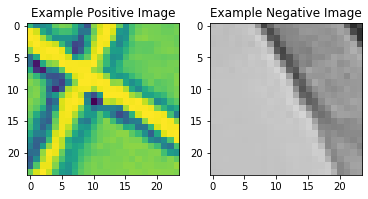

In [16]:
# Basic data summary
data_info = get_data_info(pos_train, neg_train)
print('Pos images:    ', data_info["n_pos"])
print('Neg images:', data_info["n_neg"])
print('Pos Image size:    ', data_info["pos_image_shape"])
print('Neg Image size:    ', data_info["neg_image_shape"])
print('Data type:     ', data_info["data_type"])

# Just for fun choose random car / not-car indices and plot example images   
pos_id = np.random.randint(0, len(pos_train))
neg_id = np.random.randint(0, len(neg_train))
    
# Read in car / not-car images
pos_image = mpimg.imread(pos_train[pos_id])
neg_image = mpimg.imread(neg_train[neg_id])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(pos_image)
plt.title('Example Positive Image')
plt.subplot(122)
plt.imshow(neg_image)
plt.title('Example Negative Image')

## 1. Define Features
Define features for corner detection. 

* HOG features.

### 1.1 Convert Image Datatype
The images in the training data set are of the jpeg format, with float data values range from 0-1. The test images are of the png format, range from 0-255. To be consistent with the images type in the later process. I first convert the training image data type to int type with value from 0 to 255 

In [18]:
pos_image = np.uint8(pos_image)# convert to 255
neg_image = np.uint8(neg_image)# convert to 255
neg_grey = cv2.cvtColor(neg_image, cv2.COLOR_RGB2GRAY) # convert to gray scale

### 1.4 HOG Feature
Gradient features is also used to capture the signature for a shape. However use the gradient feature directly is sensitive.  Histogram of gradient orientation allows variation  between the shape. The HOG is on the grey scale image.

In [19]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

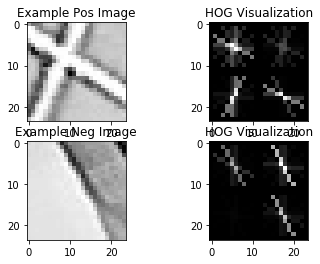

Hog features shape: (1, 1, 2, 2, 8)
Flatterned Hog features size: (32,)


In [32]:
# Define HOG parameters
orient = 8
pix_per_cell = 12
cell_per_block = 2

# Call our function with vis=True to see an image output, 
# feature_vec=False to get the feature dimension
hog_features_pos, hog_image_pos = get_hog_features(pos_image, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

hog_features_neg, hog_image_neg = get_hog_features(neg_grey, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# flattern the feature to create the feature vector
hog_1d = np.ravel(hog_features) 

# Plot the examples
fig = plt.figure()
plt.subplot(221)
plt.imshow(pos_image, cmap='gray')
plt.title('Example Pos Image')
plt.subplot(222)
plt.imshow(hog_image_pos, cmap='gray')
plt.title('HOG Visualization')
plt.subplot(223)
plt.imshow(neg_grey, cmap='gray')
plt.title('Example Neg Image')
plt.subplot(224)
plt.imshow(hog_image_neg, cmap='gray')
plt.title('HOG Visualization')
plt.show()
# test the funtion
print('Hog features shape:', hog_features.shape)
print('Flatterned Hog features size:', hog_1d.shape)

### 1.5 Extract Featuress
Combine all the extrected features

In [33]:
def extract_features(image_rgb):   
  
    # HOG feature parameters
    orient = 8
    pix_per_cell = 12
    cell_per_block = 2
       
        
    # Apply get_hog_features() with vis=False, feature_vec=True
    hog_grey = get_hog_features(image_rgb, orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True) 
        
    # Append the new feature vector to the features list
    features = hog_grey
    #features = np.concatenate((hog_grey))                                    
    return features

In [34]:
# extract features from the training image
def features_from_data(imgs):
    # Create a list to append feature vectors to
    features_all = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        
        image_rgb = np.uint8(image)# convert to 255

        features = extract_features(image_rgb) # extract features
        
        features_all.append(features)
    return features_all                  

In [36]:
# extract feature from the training set
pos_features_train = features_from_data(pos_train) # corner
neg_features_train = features_from_data(neg_train) # non-corner
# stacking pos and neg data together
X_train = np.vstack((pos_features_train, neg_features_train)).astype(np.float32)   


# extract feature from the testing set
pos_features_test = features_from_data(pos_test) # corner
neg_features_test = features_from_data(neg_test) # non-corner
# stacking car and non-car data together
X_test = np.vstack((pos_features_test, neg_features_test)).astype(np.float32)   

# print the dataset size
print("Training set:",X_train.shape)
print("Testing set :",X_test.shape)

Training set: (2540, 32)
Testing set : (319, 32)


### 1.6 Feature Normalization

In [37]:
# use standardscaler, which removing the mean and scaling to unit variance
X_scaler = StandardScaler().fit(X_train)

# Apply the scaler to the training set
scaled_X_train = X_scaler.transform(X_train)
# Apply the scaler to the testing set
scaled_X_test = X_scaler.transform(X_test)

In [38]:
# make the labels, corner get 1, non-corner get 0
# training set
y_train = np.hstack((np.ones(len(pos_features_train)), np.zeros(len(neg_features_train))))
# testing set
y_test = np.hstack((np.ones(len(pos_features_test)), np.zeros(len(neg_features_test))))

In [39]:
# print data size
print('Training set:', scaled_X_train.shape)
print('Test set    :', scaled_X_test.shape)
print('Training set:', y_train.shape)
print('Test set    :', y_test.shape)

Training set: (2540, 32)
Test set    : (319, 32)
Training set: (2540,)
Test set    : (319,)


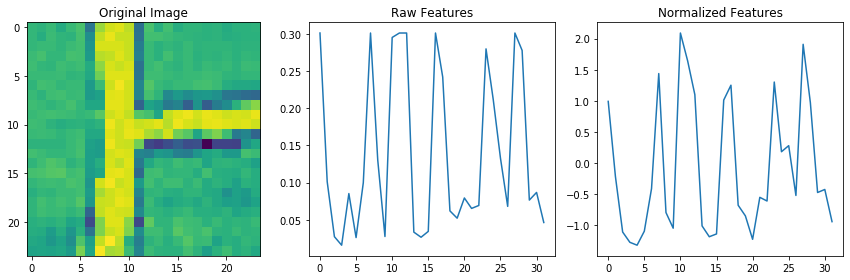

In [41]:
# plot feature normalization
pos_id = np.random.randint(0, len(pos_train))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(pos_train[pos_id]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X_train[pos_id])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X_train[pos_id])
plt.title('Normalized Features')
fig.tight_layout()

### 1.8 Make Training, Testing, and Validation set

In [42]:
# shuffle the training set
X_train, y_train = shuffle( scaled_X_train, y_train, random_state=42)

In [43]:
# split the test set into validation set (50%) and testing set (50%)
X_test, X_valid, y_test, y_valid = train_test_split(
    scaled_X_test, y_test, test_size=0.5, random_state=42)

In [44]:
print('Training set  :', X_train.shape)
print('Validation set:', X_valid.shape)
print('Testing set   :', X_test.shape)

Training set  : (2540, 32)
Validation set: (160, 32)
Testing set   : (159, 32)


## 2. Define Classifier
Train and fine-tune a random forests classifer for vehicle detection.

### 2.1 Tuning Classifier Parameters
Use grid search to find tuning the parameters

In [62]:
# Tuning Classifier Parameters
from sklearn.svm import SVC

# regulization
x = np.linspace(0.1,4.1,21)

# grid search
for i in x:
    print ("c: {} ".format(i))
    clf  = SVC(C = i,kernel='rbf',probability=True) 
    # fit the classifier
    clf.fit(X_train, y_train)
    # predict
    pred = clf.predict_proba(X_valid)[:,1]
    # compute auroc score
    auroc = roc_auc_score(y_valid, pred)
    print('auroc = ', round(auroc, 4))

c: 0.1 
auroc =  0.9276
c: 0.3 
auroc =  0.9513
c: 0.5 
auroc =  0.961
c: 0.7 
auroc =  0.9662
c: 0.8999999999999999 
auroc =  0.9726
c: 1.0999999999999999 
auroc =  0.9765
c: 1.3 
auroc =  0.9773
c: 1.5 
auroc =  0.9784
c: 1.7 
auroc =  0.9795
c: 1.9 
auroc =  0.979
c: 2.0999999999999996 
auroc =  0.9786
c: 2.3 
auroc =  0.9779
c: 2.5 
auroc =  0.9774
c: 2.6999999999999997 
auroc =  0.9774
c: 2.9 
auroc =  0.9773
c: 3.0999999999999996 
auroc =  0.9779
c: 3.3 
auroc =  0.9776
c: 3.5 
auroc =  0.9774
c: 3.6999999999999997 
auroc =  0.9774
c: 3.9 
auroc =  0.9771
c: 4.1 
auroc =  0.9763


### 2.2 Evaluate the Classifier

In [63]:
# the best parameters
clf  = SVC(C = 1.7,kernel='rbf',probability=True) 

# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train ...')

# test on training set
pred = clf.predict_proba(X_train)[:,1] # probability
pred_bi =  clf.predict(X_train) # binary class
auroc = roc_auc_score(y_train, pred)# auroc 
accuracy  = accuracy_score(y_train, pred_bi) # accuracy
print('Training auroc    =', round(auroc, 4))
print('Training accuracy =', round(accuracy, 4))

# test on test set
pred = clf.predict_proba(X_valid)[:,1] # probability
pred_bi =  clf.predict(X_valid) # binary class
auroc = roc_auc_score(y_valid, pred) # auroc 
accuracy  = accuracy_score(y_valid, pred_bi) # accuracy
print('Testing auroc    =', round(auroc, 4))
print('Testing accuracy =', round(accuracy, 4))

# test on validation set
pred = clf.predict_proba(X_test)[:,1] # probability
pred_bi =  clf.predict(X_test) # binary class
auroc = roc_auc_score(y_test, pred) # auroc 
accuracy  = accuracy_score(y_test, pred_bi) # accuracy
print('Validation auroc    =', round(auroc, 4))
print('Validation accuracy =', round(accuracy, 4))

0.66 Seconds to train ...
Training auroc    = 0.9947
Training accuracy = 0.9705
Testing auroc    = 0.9795
Testing accuracy = 0.9188
Validation auroc    = 0.9606
Validation accuracy = 0.8742


In [64]:
# more data for training always help
# I combine all the data set for training the final model
X_all = np.concatenate((X_train,X_valid,X_test))
y_all = np.concatenate((y_train,y_valid,y_test))
# shuffle the data set
X_all, y_all = shuffle( X_all, y_all, random_state=42) 
clf.fit(X_all, y_all)


SVC(C=1.7, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

## 3. Vehicle Detaction
Using the classifer on sliding windows to detect whether an image contain cars

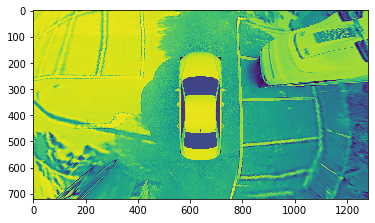

In [65]:
# load test images
img1 = cv2.imread('/Users/dalaska/APA_data/captures1/capture_screen96.bmp')
img1 = np.uint8(img1)# convert to 255
img1_grey = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY) # convert to gray scale
plt.imshow(img1_grey)

### 3.1 Sliding Window

In [66]:
# define a function to draw boxes on an image
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

In [67]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    
    # Return the list of windows
    return window_list


In [69]:
# define the minimum window size
x_min =[1, 1280]
y_min =[1, 720]
xy_min = (24, 24)

# define the maxium window size
x_max =[1, 1280]
y_max =[1, 720]
xy_max = (48, 48)

# intermedian windows
n = 3 # the number of total window sizes
x = []
y = []
xy =[]
# chose the intermediate sizes by interpolation.
for i in range(n):
    x_start_stop =[int(x_min[0] + i*(x_max[0]-x_min[0])/(n-1)), 
                   int(x_min[1] + i*(x_max[1]-x_min[1])/(n-1))]
    y_start_stop =[int(y_min[0] + i*(y_max[0]-y_min[0])/(n-1)), 
                   int(y_min[1] + i*(y_max[1]-y_min[1])/(n-1))]
    xy_window    =[int(xy_min[0] + i*(xy_max[0]-xy_min[0])/(n-1)), 
                   int(xy_min[1] + i*(xy_max[1]-xy_min[1])/(n-1))]
    x.append(x_start_stop)
    y.append(y_start_stop)
    xy.append(xy_window)
 

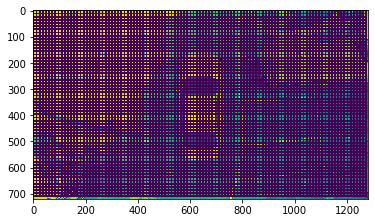

In [74]:
# visualize different window size
windows1 = slide_window(img1_grey, x_start_stop= x[0], y_start_stop = y[0], 
                    xy_window= xy[0], xy_overlap=(0.5, 0.5))
window_img1 = draw_boxes(img1_grey, windows1, color=(0, 0, 255), thick=6)
plt.imshow(window_img1)

### 3.2 Extract Features From Windows

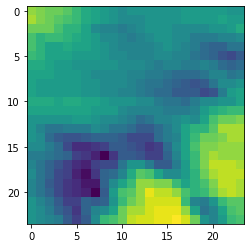

In [75]:
# preprocess the image by crop the window, and resize
def preprocess(img,window):
    # crop the image
    img_crop = img[window[0][1]:window[1][1], window[0][0]:window[1][0]]
    # resize the image to 64 by 64
    img_resized = cv2.resize(img_crop, (24, 24))
    return img_crop

# test if the function works
img = preprocess(img1_grey,windows1[1])
plt.imshow(img)

In [80]:
# extract features from a test image
def features_from_img(img,windows_all):
    # Create a list to append feature vectors to
    features_all = []
    
    for n in range(len(windows_all)):
        # Read in each one by one
        image_rgb = preprocess(img,windows_all[n])
        # extract features
        features = extract_features(image_rgb)
        # append features
        features_all.append(features)       
    # scale
    scaled_features = X_scaler.transform(features_all)
    # Return list of feature vectors
    return scaled_features

In [81]:
# Test the funcion
img_features = features_from_img(img1_grey,windows1)
# prediction
pred = clf.predict_proba(img_features)[:,1]
print('The first 10 prediction results', pred[0:10])

The first 10 prediction results [0.00818508 0.00445625 0.00087455 0.00588934 0.03713174 0.03080553
 0.08150471 0.03503543 0.45847637 0.10489105]


In [90]:
# return windows with car images
def get_windows(pred):
    windows_all = []
    for n in range(len(pred)):
        if pred[n] > 0.8: # increase the threshold will miss more True Positive
                           # the classifier have a narrow margin
            windows_all.append(windows1[n])
    return windows_all

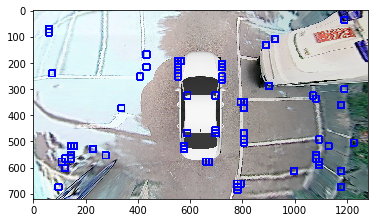

In [93]:
# return the results
windows_all = get_windows(pred)

# plot the windows put on the images
img_box = draw_boxes(img1, windows_all, color=(0, 0, 255), thick=6)
plt.imshow(img_box)